# 2018 PyCon UK - Understanding sample bias in surveys about web services

**A fundamental problem of applying surveys about specialised topics or designed for a particular community is the underlying sample bias. We have designed a simple survey that asks respondents to score a set of web services in several aspects, including the quality of their software, their social and environmental impact, and their efforts in user experience (UX) and customer support. The survey has been applied separately to the developer team at Omni Digital, and to the attendees at *2018 PyCon UK*, which took place between 15/09 and 19/09.**

The following analysis cleans up the data and uses a two-sample Kolmogorov-Smirnov test to assess whether there are any differences between the distributions of scores throughout the entire dataset, for each attribute. This is a first step towards a method to effectively recognise and assess fundamental differences in concept between two communities, as well as to explore the possibility that specialised knowledge may have a direct influence in the wider scope of things.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [2]:
# This cell reads the data from the API and cleans it up, removing unnecessary fields
fulldf = pd.read_json("http://pycon-data.omni-digital.co.uk/api/v1/survey_instances/?format=json")
df = fulldf[['completed_at', 'name', 'main', 'support', 'social', 'total']]
df = df.set_index('completed_at')

# All surveys corresponding to the Omni Digital team were taken on 14/09, while PyCon was held 15/09 to 19/09.
omni = df[:pd.datetime(2018,9,14,23,59)]
pycon = df[pd.datetime(2018,9,15):pd.datetime(2018,9,19,23,59)]

In [9]:
# We can obtain some basic information about the data set, including the list of services and the number of surveys
services = df.name.unique()
print(f"The following services have been used:")
for service in services:
    print(f"\t{service}")

total_count = fulldf.login.unique().size
omni_count = omni.loc[omni['name'] == 'Facebook'].name.count()
pycon_count = pycon.loc[pycon['name'] == 'Facebook'].name.count()

print(f"\nA total of {total_count} surveys have been submitted, of which:")
print(f"\t{omni_count} are from Omni Digital")
print(f"\t{pycon_count} are from 2018 PyCon UK")

The following services have been used:
	Google Analytics
	Amazon AWS
	Netflix
	Facebook
	Uber
	Spotify
	Squarespace
	Twitter
	Paypal
	Slack
	Reddit

A total of 30 surveys have been submitted, of which:
	8 are from Omni Digital
	22 are from 2018 PyCon UK


## Omni Digital

In [13]:
services = omni.groupby('name').mean().sort_values('total', ascending=False)

print(f"With regards to the breakdown by service, a majority of services have a score between 5 and 7.5:")
services

With regards to the breakdown by service, a majority of services have a score between 5 and 7.5:


,main,support,social,total
name,,,,
Slack,8.375000,7.285714,7.500000,7.750000
Google Analytics,8.375000,6.125000,5.125000,7.291667
Netflix,9.000000,6.250000,5.750000,7.270833
Amazon AWS,8.375000,6.428571,4.571429,6.937500
Uber,7.750000,6.250000,5.250000,6.666667
Spotify,7.750000,5.750000,5.625000,6.583333
Paypal,7.125000,5.250000,6.000000,6.333333
Squarespace,5.714286,5.571429,5.333333,5.595238
Reddit,5.875000,3.375000,5.375000,5.145833


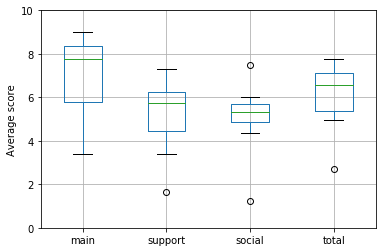

In [23]:
omni_boxplot = services.boxplot()
plt.ylim([0,10])
omni_boxplot_ylabel = plt.ylabel(f"Average score")

The box plot also shows us that, generally, the `main` scores are higher and have larger dispersion than those in `support` and `social` aspects. However, this plot ignores the dispersion within the scoring of each service, and only compares across services.

On the other hand, if we calculate the probability mass function (pmf) and the cumulative mass function (cmf) across the entire dataset, the dispersion is better accounted for.

In [68]:
bins = pd.interval_range(start=-0.5, end=10.5)
freq = omni.drop(['name'], axis=1).apply(pd.Series.value_counts, sort=False, bins=bins)
pmf = freq/np.sum(freq)
cmf = np.cumsum(pmf)

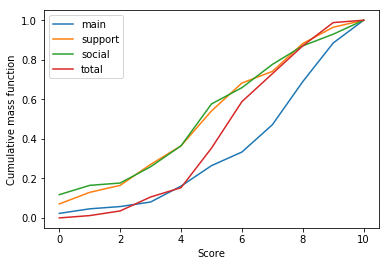

In [80]:
for key in cmf.keys():
    plt.plot(bins.mid, cmf[key])

legend = plt.legend()
xlabel = plt.xlabel(f"Score")
ylabel = plt.ylabel(f"Cumulative mass function")

We can see that there seems to be an alignment of the scores in `social` and `support` attributes, but the `main` scores seem to follow a different distribution. We can test whether this assumption is statistically significant using a two-sample Kolmogorov-Smirnov test. The statistic is calculated as the supremum of the absolute differences:

$$ D_{n,m} = \sup_x \left| F_{1,n}(x) - F_{2,m}(x) \right|,$$

and the null hypothesis, which can be phrased as "_the two samples are drawn from the same distribution_", is rejected if:

$$ D_{n,m} > c(\alpha)\sqrt{\frac{n + m}{nm}}.$$

In general, the value of the baseline $c(\alpha)$ is given by:

$$ c(\alpha) = \sqrt{-\frac{1}{2}\ln\left(\frac{\alpha}{2}\right)} $$

Alternatively, we can calculate the p-value of a given $D_{n,m}$ with known $n$ and $m$ by re-writing the formula:

$$ p\left(D_{n,m}, n, m\right) = 2e^{-2D_{n,m}^2\frac{nm}{n+m}} $$

In [83]:
def c(a):
    return np.sqrt(-0.5*np.log(a/2))

def pval(d, n, m):
    return 2*np.exp(-2*d**2*n*m/(n+m))

for key1 in cmf.drop(['total'], axis=1).keys():
    n = np.sum(freq[key1])
    for key2 in cmf.drop(['total', key1], axis=1).keys():
        m = np.sum(freq[key2])
        dnm = np.max(np.abs(cmf[key1]-cmf[key2]))
        ca = c(0.05)*np.sqrt((n+m)/(n*m))
        pv = pval(dnm, n, m)
        
        print(f"{key1}\t{key2}\t{dnm}\t{ca}\t{pv}\t{dnm>ca}")

main	support	0.34901960784313724	0.2071225423255308	5.648703459912517e-05	True
main	social	0.3254901960784313	0.2071225423255308	0.00022112253791288142	True
support	main	0.34901960784313724	0.2071225423255308	5.648703459912517e-05	True
support	social	0.047058823529411764	0.20832326277472024	1.6568395240038107	False
social	main	0.3254901960784313	0.2071225423255308	0.00022112253791288101	True
social	support	0.047058823529411764	0.20832326277472024	1.6568395240038107	False


These results show that there is a significant difference between the distributions obtained for the `main` scores and the `social` and `support` scores. It is a good indicator that the expectations of the 